In [1]:
#!/usr/bin/python3.8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks
# import tensorflow as tf
from sklearn.model_selection import train_test_split


%matplotlib notebook

In [2]:
# ================= CONSTANTS =================
PMT_PULSE_LENGTH = 1500  # Sample lenght of a typical pulse
SAMPLES_BEFORE_PEAK = 4  # Samples to store before peak detection. MUST BE SMALLER THAN 8

In [3]:
df=pd.read_csv("../data_Cs137/20210715_173047/20210715_173047_0.csv", index_col=0)

In [4]:
df

TBP:67641  TBP:81803  TBP:80956  TBP:82806  TBP:68766  TBP:67628  \
0            137        137        137        137        137        137   
1            137        136        136        136        136        136   
2            136        137        136        137        137        136   
3            136        136        136        136        136        136   
4            137        136        137        137        137        137   
...          ...        ...        ...        ...        ...        ...   
65529        136        136        136        136        136        136   
65530        137        137        137        137        137        137   
65531        136        137        136        136        136        136   
65532        137        136        137        136        137        137   
65533        136        136        136        136        136        135   

       TBP:71328  TBP:66152  TBP:67563  TBP:66589  ...  TBP:76694  TBP:67247  \
0            137        137        137        137  ...        136        137   
1            136        136        136        135  ...        136        135   
2            136        137        137        137  ...        137        137   
3            136        137        136        135  ...        136        136   
4            137        137        137        137  ...        137        138   
...          ...        ...        ...        ...  ...        ...        ...   
65529        136        136        136        136  ...        136        136   
65530        137        136        136        137  ...        137        137   
65531        136        136        136        136  ...        136        136   
65532        135        136        137        137  ...        137        137   
65533        135        135        136        136  ...        136        137   

       TBP:69111  TBP:70392  TBP:71145  TBP:78225  TBP:74130  TBP:70113  \
0            137        137        137        136        136        137   
1            136        136        136        136        137        136   
2            137        137        137        136        137        137   
3            136        136        136        136        136        136   
4            138        137        137        136        137        137   
...          ...        ...        ...        ...        ...        ...   
65529        136        136        136        136        137        137   
65530        137        136        136        136        136        137   
65531        136        136        136        136        136        136   
65532        129        137        137        136        137        137   
65533        128        137        136        136        136        136   

       TBP:69657  TBP:80324  
0            137        137  
1            136        136  
2            137        137  
3            136        137  
4            137        138  
...          ...        ...  
65529        136        136  
65530        137        136  
65531        136        135  
65532        134        137  
65533        133        136  

[65534 rows x 4007 columns]

# Peak detection

In [5]:
def pkdetect(x, thr=100, pkh=10):
    peak=[]
    lmax=0
    imax=0
    count=0
    for i in range(1,len(x)):
        if x[i] <= thr:
            pass
        elif x[i] > lmax:
            imax=i
            lmax=x[i]
        elif ((lmax-x[i-1]) > pkh) and (x[i]-x[i-1])>0:
            peak.append(imax)
            lmax=0
        else:
            pass
            
    return peak

# Individual pulse isolation and area estimation

In [6]:
#Isolating individual pulses within a trace

def isolatePulses(singleTrace, peakIndexesList, pulseLength, samplesBeforePeak):
    singleTrace = singleTrace.tolist()
    i = 0 #Input pulse index
    outputPulseIndex = 0
    diffFromLastPeak = pulseLength #In order to classify the first pulse as a valid event
    isolatedPulses = [] #Output variable (list of pulse samples) that stores each valid pulse
    
    #Be sure to slide along the whole trace, avoiding short pulses located at the end
    while ((i < len(peakIndexesList)) and (peakIndexesList[i] <= len(singleTrace) - pulseLength)):
        #print("Diff from last peak: " + str(diffFromLastPeak))
        if(diffFromLastPeak >= pulseLength):
            lowerPulseRange = peakIndexesList[i] - samplesBeforePeak #Be sure to record some samples before peak
            upperPulseRange = lowerPulseRange + pulseLength #Store the whole pulse
            isolatedPulses.append([])
            isolatedPulses[outputPulseIndex].extend(singleTrace[lowerPulseRange:upperPulseRange])
            #print("OutputPulseIndex: " + str(outputPulseIndex))
            outputPulseIndex += 1
            diffFromLastPeak = 0
        i += 1
        if i < len(peakIndexesList):
            diffFromLastPeak += peakIndexesList[i] - peakIndexesList[i-1] #Check if peaks are distant enough
            
        else:
            break
    
    return isolatedPulses
        

In [7]:
#Isolating individual pulses within a trace using multithreading

def isolatePulsesMP(singleTrace, peakIndexesList, pulseLength, samplesBeforePeak, queue):
    singleTrace = singleTrace.tolist()
    i = 0 #Input pulse index
    outputPulseIndex = 0
    diffFromLastPeak = pulseLength #In order to classify the first pulse as a valid event
    isolatedPulses = [] #Output variable (list of pulse samples) that stores each valid pulse
    
    
    #Be sure to slide along the whole trace, avoiding short pulses located at the end
    while ((i < len(peakIndexesList)) and (peakIndexesList[i] <= len(singleTrace) - pulseLength)):
        #print("Diff from last peak: " + str(diffFromLastPeak))
        if(diffFromLastPeak >= pulseLength):
            lowerPulseRange = peakIndexesList[i] - samplesBeforePeak #Be sure to record some samples before peak
            upperPulseRange = lowerPulseRange + pulseLength #Store the whole pulse
            isolatedPulses.append([])
            isolatedPulses[outputPulseIndex].extend(singleTrace[lowerPulseRange:upperPulseRange])            
            #print("OutputPulseIndex: " + str(outputPulseIndex))
            outputPulseIndex += 1
            diffFromLastPeak = 0
        i += 1
        if i < len(peakIndexesList):
            diffFromLastPeak += peakIndexesList[i] - peakIndexesList[i-1] #Check if peaks are distant enough
            
        else:
            break
        
    queue.put(isolatedPulses[1:])
        

# FIR Filtering of each isolated pulse

In [8]:
firCoefsCs137 = pd.read_csv("../FirCoefficients_Cs137.csv", index_col = 0)
firCoefsCs137 = firCoefsCs137[firCoefsCs137.columns[0]].values
firCoefsCs137

array([0.44206127, 0.09182476, 0.42233285, ..., 0.21294929, 0.56172999,
       0.21451062])

In [355]:
def filterSinglePulse(pulse, coefficients):
    init = list(pulse)
#     init = [max(pulse)]*len(pulse)
#     init.extend(pulse)
#     init.extend([max(pulse)]*len(pulse))
    x = np.convolve(init, np.flip(coefficients[:400]), mode = "valid")
    return x.tolist()

In [20]:
#Dataframe with individual pulses
dfPulses = pd.DataFrame(columns = [0])

In [21]:
df[df.columns[1]]

0        137
1        136
2        137
3        136
4        136
        ... 
65529    136
65530    137
65531    137
65532    136
65533    136
Name: TBP:81803, Length: 65534, dtype: int64

In [29]:
import multiprocessing as mp

THREADS = 12


mpQueues = [mp.Queue() for i in range(THREADS)]
nTraces = len(df.T)
nTraces = 10
traceIdx = 0



for i in range(0, nTraces, THREADS):
    runningThreads = 0
    for j in range(THREADS):
        currentTraceIndex = i + j
        if currentTraceIndex < nTraces:
            runningThreads += 1
            thisTrace = df[df.columns[currentTraceIndex]]
            peaksList = pkdetect(thisTrace, 10, 10)
            p = mp.Process(target = isolatePulsesMP, args = (thisTrace, peaksList, PMT_PULSE_LENGTH, SAMPLES_BEFORE_PEAK, mpQueues[j]))
            p.start()
            print("Processing trace " + str(currentTraceIndex + 1) + "/" + str(nTraces))
    for k in range(runningThreads):
#         print("Joining thread " + str(k+1) + "/" + str(runningThreads))
        testList = []
        testList.extend(mpQueues[k].get())
        testList = pd.Series(testList)
        for l in testList:
#             filteredPulse = filterSinglePulse(l[0], firCoefsCs137)
#             dfPulses[traceIdx] = filteredPulse
            dfPulses[traceIdx] = l[0]
            traceIdx += 1
        p.join()
        
print("Done!")
        




# for i in range(nTraces):
#     testList.append([])
#     thisTrace = df[df.columns[i]]
#     peaksList = pkdetect(thisTrace, 10, 10)
#     individualPulses = isolatePulses(thisTrace, peaksList, PMT_PULSE_LENGTH, SAMPLES_BEFORE_PEAK)[1:]
#     #print("Individual pulses: " + str(individualPulses))
#     for j in individualPulses:
#         #print("j: " + str(j))
#         dfPulses[traceIdx] = j
#         traceIdx += 1

Processing trace 1/10
Processing trace 2/10
Processing trace 3/10
Processing trace 4/10
Processing trace 5/10
Processing trace 6/10
Processing trace 7/10
Processing trace 8/10
Processing trace 9/10
Processing trace 10/10
Done!


In [23]:
dfPulses

0          1          2          3          4          5   \
0     29.387955  29.387955  29.387955  27.028339  29.173445  28.958934   
1     76.957008  76.957008  76.957008  70.777978  76.395278  75.833548   
2     29.174053  29.174053  29.174053  26.831610  28.961103  28.748154   
3     77.532706  77.532706  77.532706  71.307453  76.966774  76.400842   
4     30.480882  30.480882  30.480882  28.033512  30.258394  30.035905   
...         ...        ...        ...        ...        ...        ...   
1495  54.315971  54.315971  54.315971  49.954835  53.919504  53.523037   
1496  11.486090  11.486090  11.486090  10.563849  11.402250  11.318409   
1497  57.859600  57.859600  57.859600  53.213939  57.437267  57.014934   
1498  12.579992  12.579992  12.579992  11.569920  12.488167  12.396342   
1499  60.562393  60.562393  60.562393  55.699719  60.120332  59.678271   

             6          7          8          9   ...         52         53  \
0     29.173445  28.744424  29.387955  29.173445  ...  29.387955  28.958934   
1     76.395278  75.271818  76.957008  76.395278  ...  76.957008  75.833548   
2     28.961103  28.535205  29.174053  28.961103  ...  29.174053  28.748154   
3     76.966774  75.834910  77.532706  76.966774  ...  77.532706  76.400842   
4     30.258394  29.813417  30.480882  30.258394  ...  30.480882  30.035905   
...         ...        ...        ...        ...  ...        ...        ...   
1495  53.919504  53.126570  54.315971  53.919504  ...  54.315971  53.523037   
1496  11.402250  11.234569  11.486090  11.402250  ...  11.486090  11.318409   
1497  57.437267  56.592602  57.859600  57.437267  ...  57.859600  57.014934   
1498  12.488167  12.304518  12.579992  12.488167  ...  12.579992  12.396342   
1499  60.120332  59.236210  60.562393  60.120332  ...  60.562393  59.678271   

             54         55         56         57         58         59  \
0     28.315402  29.173445  29.387955  29.387955  29.387955  29.387955   
1     74.148358  76.395278  76.957008  76.957008  76.957008  76.957008   
2     28.109306  28.961103  29.174053  29.174053  29.174053  29.174053   
3     74.703046  76.966774  77.532706  77.532706  77.532706  77.532706   
4     29.368441  30.258394  30.480882  30.480882  30.480882  30.480882   
...         ...        ...        ...        ...        ...        ...   
1495  52.333636  53.919504  54.315971  54.315971  54.315971  54.315971   
1496  11.066889  11.402250  11.486090  11.486090  11.486090  11.486090   
1497  55.747936  57.437267  57.859600  57.859600  57.859600  57.859600   
1498  12.120868  12.488167  12.579992  12.579992  12.579992  12.579992   
1499  58.352087  60.120332  60.562393  60.562393  60.562393  60.562393   

             60         61  
0     29.387955  29.387955  
1     76.957008  76.957008  
2     29.174053  29.174053  
3     77.532706  77.532706  
4     30.480882  30.480882  
...         ...        ...  
1495  54.315971  54.315971  
1496  11.486090  11.486090  
1497  57.859600  57.859600  
1498  12.579992  12.579992  
1499  60.562393  60.562393  

[1500 rows x 62 columns]

In [14]:
dfPulses.to_csv("../PeakDetection_Cs137_IndividualPulses_Filtered.csv")

<IPython.core.display.Javascript object>


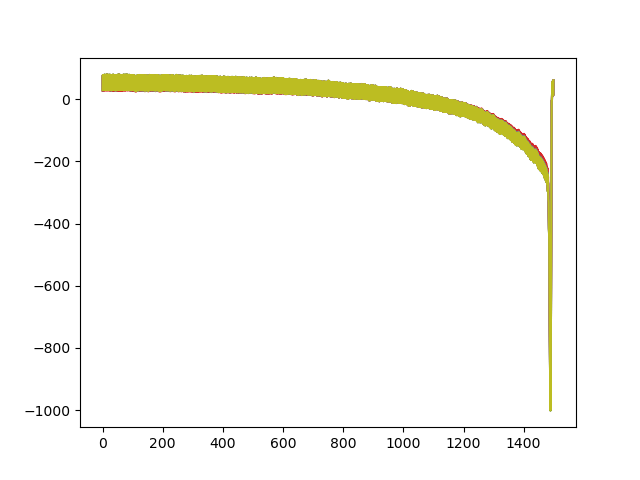

In [24]:
%matplotlib notebook

nPlots = 9
startIndex = 0


ax = plt.plot(dfPulses[dfPulses.columns[startIndex]])

for i in range(nPlots - 1):
    plt.plot(dfPulses[dfPulses.columns[startIndex + 1 + i]])
    plt.plot()

In [102]:
dfIndividual = pd.read_csv("../PeakDetection_Cs137_IndividualPulses.csv", index_col = 0)


<IPython.core.display.Javascript object>


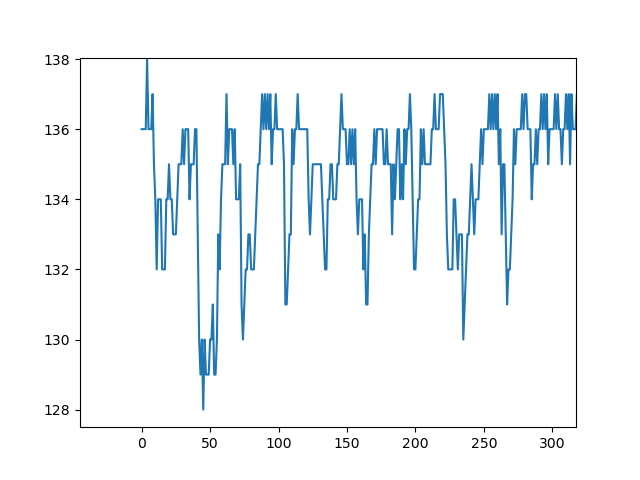

[]

In [375]:
%matplotlib notebook
dfIndividual[dfIndividual.columns[6]].plot()
plt.plot()

In [356]:
testPulses = dfIndividual[dfIndividual.columns[0:100]]

In [357]:
filteredPulses = []
for i in testPulses:
    filteredPulses.append(filterSinglePulse(testPulses[i].values,firCoefsCs137))

<IPython.core.display.Javascript object>


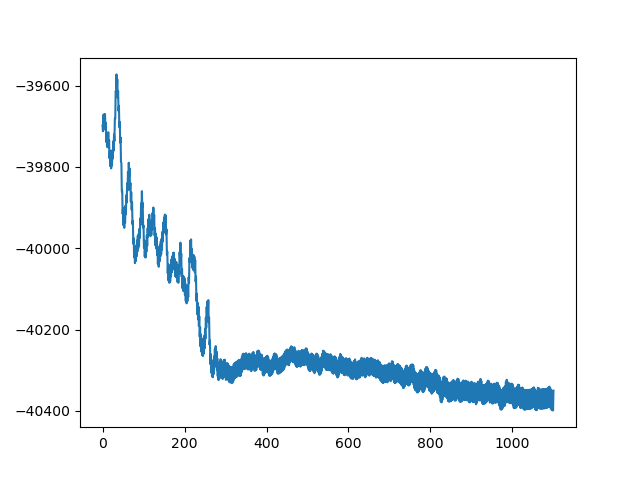

In [374]:
%matplotlib notebook
plt.plot(filteredPulses[6])
plt.show()

# Area computation

In [ ]:
def singlePulseToArea(singlePulse):
    newPulse = max(singlePulse) - singlePulse
    return sum(newPulse)

In [16]:
dfAreas = pd.DataFrame(columns = ["Cs137"])

In [17]:
dfAreas["Cs137"] = dfPulses.apply(singlePulseToArea, axis = 0)

In [18]:
dfAreas

Cs137
0      119237.578469
1      119237.578469
2      119237.578469
3      109663.758300
4      118367.231180
...              ...
26078  118367.231180
26079  115756.189316
26080  114015.494740
26081  115756.189316
26082  119237.578469

[26083 rows x 1 columns]

In [19]:
dfAreas.to_csv("../PeakDetection_Cs137_Areas_Filtered.csv")

<IPython.core.display.Javascript object>


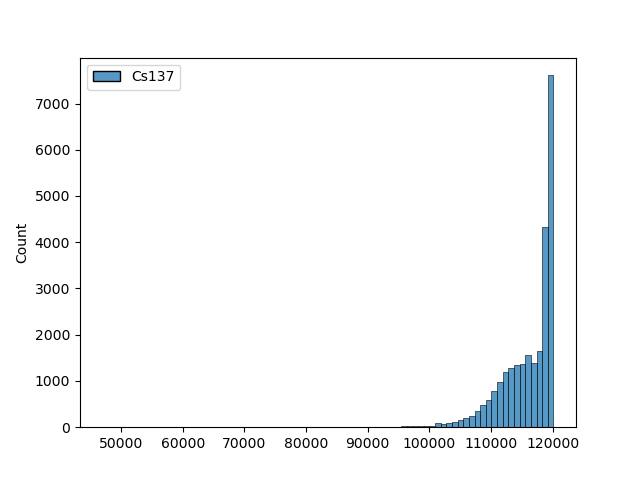

In [24]:
%matplotlib notebook
sns.histplot(dfAreas, bins = 80)
plt.show()

In [96]:
dfAreasCo60 = pd.read_csv("../PeakDetection_Co60_Areas.csv", index_col = 0)

In [103]:
dfAreasCs137 = dfAreas[:len(dfAreasCo60)]

In [114]:
dfAreasCo60

60Co
0      8142
1      3884
2      3683
3      5881
4      2574
...     ...
24199  3637
24200  6098
24201  7142
24202  3895
24203  6781

[24204 rows x 1 columns]

<IPython.core.display.Javascript object>


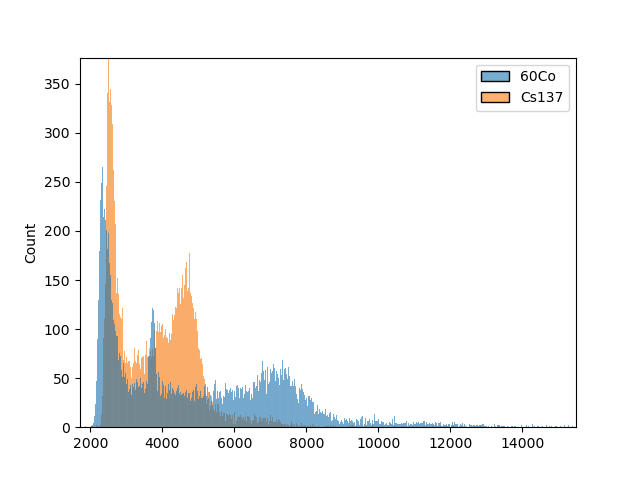

In [124]:
%matplotlib notebook

sns.histplot(data = [dfAreasCo60["60Co"], dfAreasCs137["Cs137"]], alpha = 0.6, bins = 10000)


plt.show()